# Trabajo practico 1

integrantes:
Alvarez Vico Jazmín
Cortes Conde Tito Maria Javier
Frassia Fernando Nicolas


Aclaraciones preliminares

sobre la hipótesis nula:
Se define hipótesis nula como la proposición de que dos fenómenos medidos no están relacionados.
Al rechazar la hipótesis nula podemos decir que es probable que dicha relación si exista.

Sobre el p valor:
el p valor nos indica la probabilidad de obtener un valor igual o más extremo al obtenido a travez de una medición, asumiendo cierta la hipótesis nula.

Al obtener un p valor chico (tradicionalmente se considera chico un p valor meno o igual a 0,05) rechazamos la hipótesis nula. Pues esto significa que es muy poco probable obtener un resultado semejante con un espacio muestral distinto al que tenemos.

En esta caso decimos que nuestra muestra es estadísticamente significativa, reforzando nustra hipótesis alternativa. 

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random

funciones auxiliares

In [2]:
def igual_varianza(l1,l2):
    estadistico = np.var(l1) / np.var(l2) 
    pval=  sp.stats.f.cdf(estadistico,len(l1)-1, len(l2)-1)
    #print("pval = " + str(pval))
    return pval>=0.05

def distribucion_normal(l1):
    return sp.stats.shapiro(l1)[1] >=0.05

def test_permutaciones(l1,l2,cant_permutaciones):
    
    meanl1 = np.mean(l1)
    meanl2 = np.mean(l2)
    l1 = [x for x in l1]
    l2 = [x for x in l2]
    muestra = l1+l2
    il1 = len(l1)-1
    delta=[] 
    delta.append(meanl2-meanl1)

    for i in range(0,cant_permutaciones):

        random.shuffle(muestra)
        currentDelta = np.mean(muestra[:il1+1]) - np.mean(muestra[il1+1:])
        delta.append(currentDelta)

    aux = 1
    for i in range(1,len(delta)):
        if delta[0] <= delta[i]:
            aux += 1
    pval = aux/len(delta)
    
    plt.axvline(x=delta[0], color='r')
    plt.hist(delta)
    plt.show()
    print("p value = " + str(pval)) 

    
def  wilcoxon_apareadas(l1,l2):
    pval= sp.stats.wilcoxon(l1,l2)[1]
    print("p value = " + str(pval))
    
def igual_media_apareada(l1,l2,cant_permut): 
    if distribucion_normal(l1) and distribucion_normal(l2):
        print("checkeo distribución normal: No concluyente, suponemos normalidad")
        ig_var = igual_varianza(l1,l2)
        ig_var2 = igual_varianza(l2,l1)
        if (ig_var and ig_var2):            
            print("checkeo varianza: No concluyente, suponemos igual varianza")
            print("utilizamos test de Student")
            pval = sp.stats.ttest_rel(l1, l2)[1]
            print("p value = " + str(pval) )
        else:
            print("checkeo varianza: NO")
            print("utilizamos test de Welsh")
            pval = sp.stats.ttest_ind(l1, l2)[1]
            print("p value = " + str(pval) )
            
    print("utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal")
    wilcoxon_apareadas(l1,l2)
            
def igual_media_1muesrta(l):
    if distribucion_normal(l):
        print("checkeo distribución normal: ok") 
        meanl = np.mean(l)
        pval = sp.stats.ttest_1samp(l,meanl)[1]
        print("p value = " + str(pval) )
    

    
def anova2ways():
    df=DataFrame()
    df.read_tbl('tiempos.txt')
    df['id'] = xrange(len(df['len']))
 
    print(df.anova('len', sub='id', bfactors=['supp', 'dose']))

#divide por tres por que quiero el promedio, es una funcion muy especifica usarla con quidado
def sumLista(l1, l2):
    l3 =[]
    for i in range(len(l1)):
        l3.append((l1[i] +l2[i])/3.0)
    
    return l3
    



Lectura de datos

In [3]:
df = pd.read_csv('tiempos.txt', sep=' ')

Gráficos preliminares

/home/javier/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


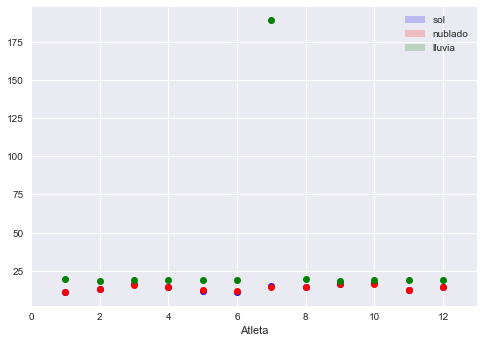

In [4]:
sol = sns.tsplot(time=df['Atleta'], data=df['tiempo_sol'], interpolate=False, color="blue")

nublado = sns.tsplot(time=df['Atleta'], data=df['tiempo_nublado'], interpolate=False, color="red")

lluvia = sns.tsplot(time=df['Atleta'], data=df['tiempo_lluvia'], interpolate=False, color="green")

sns.plt.legend([sol, nublado, lluvia], labels=["sol","nublado","lluvia"])

sns.plt.show()


podemos observar que un dato tiene un valor "extraño", tiene un valor mucho mayor a los demas. Suponemos que se debe a un error de tipeo.


Limpieza

Tomamos la decisión de borrar la fila.


/home/javier/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


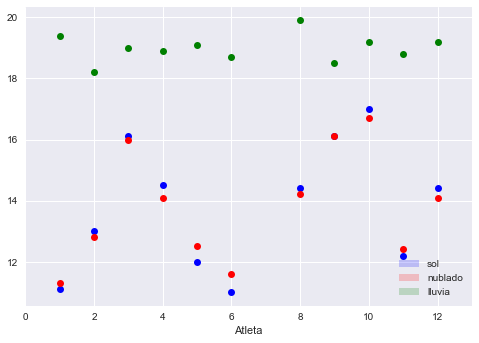

In [5]:
df.drop(df[df.tiempo_lluvia > 180.0].index, inplace=True)

sol = sns.tsplot(time=df['Atleta'], data=df['tiempo_sol'], interpolate=False, color="blue")

nublado = sns.tsplot(time=df['Atleta'], data=df['tiempo_nublado'], interpolate=False, color="red")

lluvia = sns.tsplot(time=df['Atleta'], data=df['tiempo_lluvia'], interpolate=False, color="green")

sns.plt.legend([sol, nublado, lluvia], labels=["sol","nublado","lluvia"])

sns.plt.show()


# Análisis de Datos

# Hipótesis: Los atletas son más lentos en días de lluvias que en días soleados.

## Hipótesis nula: Los atletas son igual o más rápidos en días de lluvia que en días soleados.

Para probar esto utilizaremos el test de wilcoxon de rank-sum, que como hipótesis nula dice que las muestras vienen de una misma distribución. Si se rechaza esto, sabremos que no son iguales, pero no sabremos cuando es que los atletas son son más rápidos que los otros. por esto usaremos un test de permutaciones para tratar de rechazar la totalidad de la hipótesis nula.

p value = 7.1052632886e-05


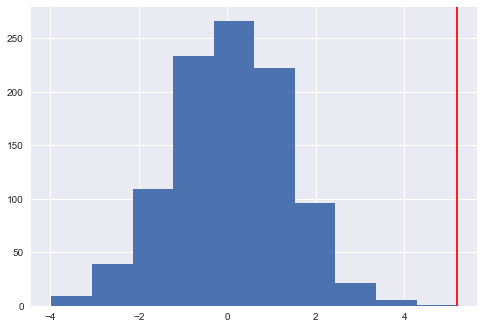

p value = 0.000999000999000999


In [6]:
#igual_media_apareada(df['tiempo_sol'], df['tiempo_lluvia'],1000)
aux = sp.stats.ranksums(df['tiempo_sol'], df['tiempo_lluvia'])
print("p value = "+str(aux[1]))
test_permutaciones(df['tiempo_sol'],df['tiempo_lluvia'],1000)




podemos observar que de ambos tests obtenemos p valores pequños, a raíz de esto podemos rechazar ambas partes de nuestra hipótesis nula, validando nuestra hipótesis alternativa. Es decir, los atletas son más lentos en días de lluvia que en días soleados.



Hipótesis: El cielo nublado no influye en los tiempos de los atletas

Hipotesś nula: el cielo nublado influye en los tiempos de los atletas


checkeo distribución normal: No concluyente, suponemos normalidad
checkeo varianza: No concluyente, suponemos igual varianza
utilizamos test de Student
p value = 1.0
utilizamos test de Wilcoxon, sin asumir igual varianza y distribucion normal
p value = 0.959221134457


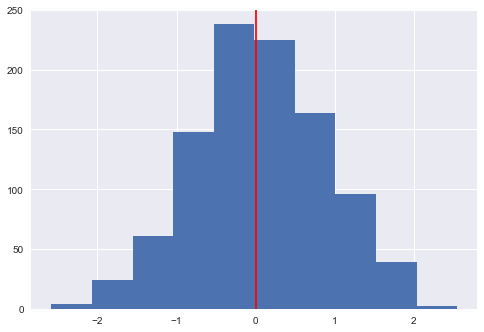

p value = 0.5224775224775224


In [7]:
igual_media_apareada(df['tiempo_sol'], df['tiempo_nublado'],1000)
test_permutaciones(df['tiempo_sol'],df['tiempo_nublado'],1000)

# Hipótesis: el clima influye en la velocidad del atleta.

## Hipótesis Nula: el clima no influye en la velocidad del atleta. 

⁠⁠⁠Para decidir si el clima  influye en la velocidad de los atletas, basta con ver que existe una diferencia estadística entre los tiempos medidos en dos climas distintos. 
En los tests anteriores analizamos dos casos “nublado-sol” y “sol-lluvia”. 
En el primer caso no pudimos sacar conclusiones de que dicha afección sea cierta, sin embargo en el segundo caso, pudimos concluir que era altamente probable que la lluvia afectara el tiempo de los atletas. 
A raíz de esto, podemos decir entonces que efectivamente el clima afecta a los atletas.

# Hipótesis: la velocidad en días de lluvia es independiente del atleta

## hipótesis nula: la velocidad en días de lluvia depende del atleta.

Para testear nuestra hipótesis nula vamos a crear un test de permutaciones con una nueva variable aleatoria, esta se define como el promedio en tiempos de un atleta, es decir vamos a sumar los tiempos de cada atleta en los distintos climas y sacar su promedio.Esta va a ser nuestra nueva variable aleatoria.
Luego vamos a permutar las velocidades en dias de lluvia y volveremos a caluclar el promedio.
si nos da un p valor muy bajo entonces la descartaremos, respaldando nuestra hipótesis nula. 



/home/javier/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:518: UserWarning: You have mixed positional and keyword arguments, some input will be discarded.
  warnings.warn("You have mixed positional and keyword "


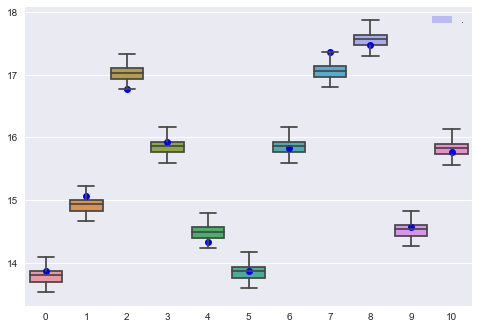

In [8]:
#suma elemento a elemento
df['tiempo_sol+nublado'] = df['tiempo_sol'] + df['tiempo_nublado']

#paso a lista
tiempo_sol_nublado = [x for x in df['tiempo_sol+nublado']]
tiempo_lluvia = [x for x in df['tiempo_lluvia']]
#promedio x atleta
tiempo_prom = sumLista(tiempo_sol_nublado, tiempo_lluvia)

#print(tiempo_sol_nublado)
#print(tiempo_lluvia)
#print(tiempo_prom)
#hay un delta x atleta
delta =[]
delta.append(tiempo_prom)
#permuto
for i in range(15000):
    random.shuffle(tiempo_lluvia)
    tiempo_prom = sumLista(tiempo_sol_nublado, tiempo_lluvia)
    delta.append(tiempo_prom)

dataset = pd.DataFrame(data=delta)
#print(dataset)
#print(delta)

tprom = sns.tsplot( tiempo_prom, interpolate=False, color="blue")
sns.plt.legend([tiempo_prom], labels=["."])
sns.boxplot( data=dataset)
plt.show()

Este gráfico es un boxPlot de los datos obtenidos tras el proceso de permutar. Además está superpuesto el promedio original de las velocidades de los atletas. En general, el promedio original se encuentra dentro del rango de las cajas, sin embargo algunos valores llegan hasta el borde del bigote, estando muy cerca de poder considerarlos valores atípicos.

También se puede notar que el cincuenta porciento de los casos para cada atleta entra en un rango de tiempo muy chico, es decir que aunque se modifican los tiempos de lluvia el promedio sigue siendo relativamente similar.

Por un lado, que los valores originales estén dentro de las cajas y que estas tengan un tamaño reducido nos haría creer tener indicios de que la velocidad en días de lluvia no depende de los atletas, sin embargo al tener algunos valores tan al borde de ser outlayers nos hace sospechar que quizás no tengamos suficiente información para asegurar esto.


### Histrogramas

11


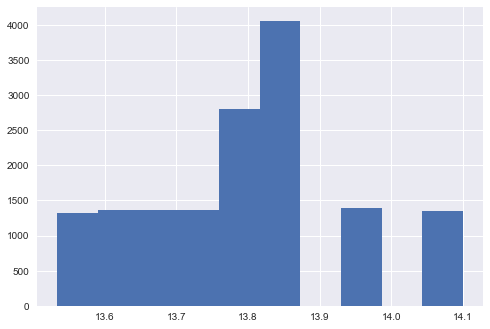

p value = 0.18272115192320512


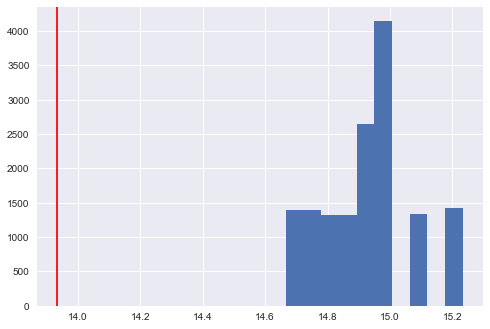

p value = 0.9999333377774815


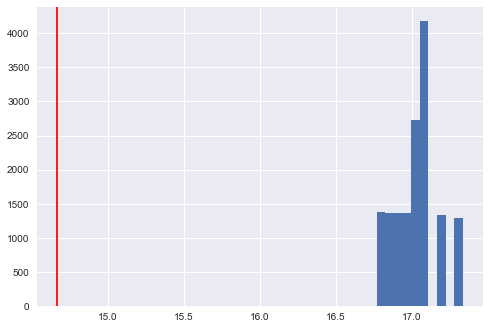

p value = 0.5418972068528765


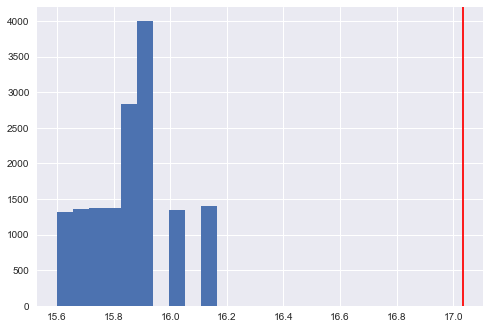

p value = 0.6384907672821812


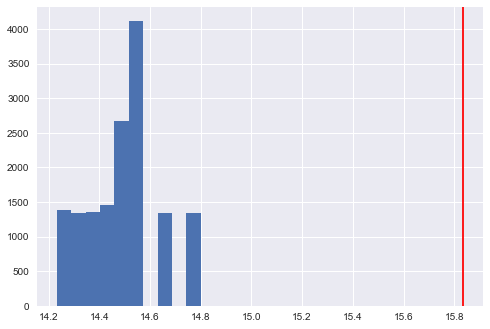

p value = 0.45330311312579163


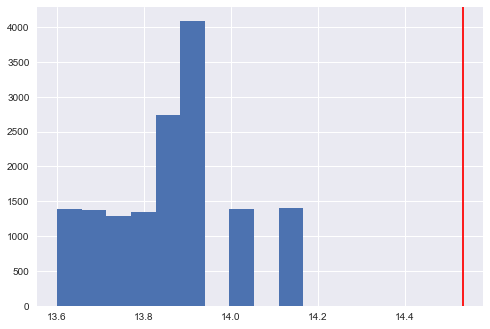

p value = 0.8159456036264249


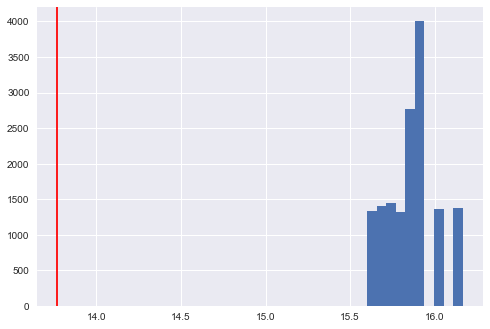

p value = 0.09132724485034331


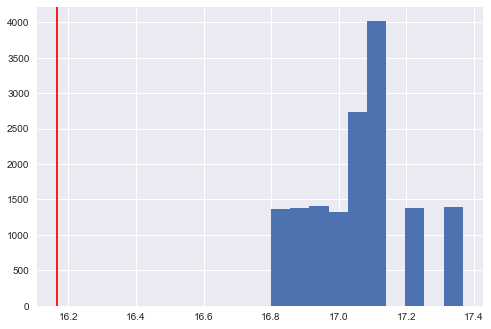

p value = 0.9088060795946937


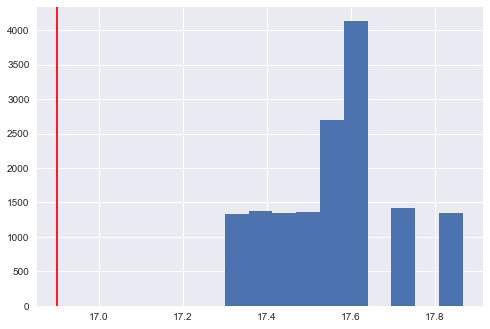

p value = 0.36464235717618826


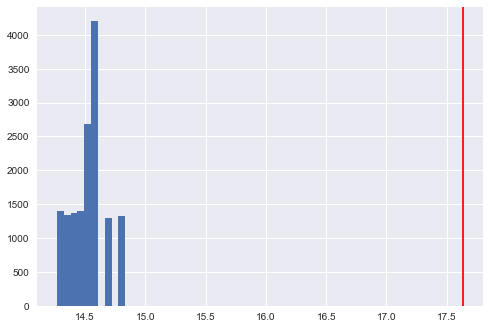

p value = 0.7265515632291181


In [9]:
lendelta = len(delta)-1    
print(len(delta[1]))
for i in range(0,10):    
    aux = []
    acum=0
    for j in range(0,lendelta):
        intaux = delta[j][i]
        aux.append(intaux) 
        if delta[0][i] <= intaux:
            acum += 1
    pval=acum/len(delta)   
    plt.hist(aux)
    plt.show()    
    plt.axvline(x=delta[0][i], color='r')
    print("p value = " + str(pval))

tras ver estos histogramas, podemos observar que los p valores son demasiado altos como para poder rechazar nuestra hipótesis nula. 
En uno de los histogramas correspondientes a los valores más extremos (los que en los diagramas de cajas nos quedan prácticamente como outlayers)  podemos observar que la línea del promedio original nos queda desfasada respecto al p valor obtenido, este es un resultado bastante extraño y no pudimos concluir exactamente por qué ocurre.
El comportamiento que no podemos explicar se puede ver en distintos histogramas, pero vamos a hablar de uno genérico. Este tiene al final del gráfico el delta original mostrandonos un p valor significativo, es decir que un gran porcentaje de los datos son: o el delta original, o estan a la derecha de este. Pero todos los datos se encuentran a la izquierda del delta antes mencionado, lo cual carece de explicación racional. 

Concluimos que no tenemos suficientes datos como para rechazar nuestra hipótesis nula, sin embargo intuitivamente creemos que con un set de muestreo más amplio es probable que podamos reforzar la hipótesis alternativa.

# Consejos al entrenador:
1- Recomendamos que los atletas entrenen en días de lluvia, ya que sostenemos que hay altas probabilidades de que los atletas sean más lentos en estos días, de esta forma creemos que el entrenamiento tendra mejor rendimiento.

2- Recomendamos que al poner fechas de competencia se busque evitar días de lluvia.

3- Tomar más mediciones para hacer análisis más rigurosos, ya que algunos test funcionan mejor teniendo un espacio muestral mas grande, sobretodo los no paramétricos.

4- Que sea más atento al tomar mediciones para no cometer errores ya que dificulta el análisis de los mismos, con resultados que varian desde tomar una hipotesis como verdadera cuando no lo era o tener que desechar el dato.